In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import chess
import random
import numpy as np
import matplotlib.pyplot as plt

## Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Tcc/uci_games.csv")
df = df[df["AN"].map(len) > 14]
import ast
def convert_to_list(string):
    try:
        return ast.literal_eval(string)
    except ValueError:
        return []
df['AN'] = df['AN'].apply(convert_to_list)

In [ ]:
alphabet_to_number = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7
}

number_to_alphabet = {v: k for k, v in alphabet_to_number.items()}
def fen_to_numeric(fen_string,piece):
    piece_placement = fen_string.split()[0]
    board = [[0] * 8 for _ in range(8)]
    row_index = 0
    col_index = 0

    for char in piece_placement:
        if char == '/':
            row_index += 1
            col_index = 0
        elif char.isdigit():
            col_index += int(char)
        elif char.lower() == piece.lower():
            piece_value = 1
            if char.islower():
                piece_value *= -1
            board[row_index][col_index] = piece_value
            col_index += 1
        else:
          board[row_index][col_index] = 0
          col_index += 1

    return board

def matrix_board(move_list):
  board = get_X_board(move_list)
  pieces = ["p","k","r","n","q","b"]
  layers = []
  for piece in pieces:
    layers.append(fen_to_numeric(board.fen(),piece))
  return np.stack(layers)

def get_X_board(move_list):
  board = chess.Board()
  for move in move_list:
    board.push_uci(move)
  return board

def move_matrix(move):
  uci_move = move

  from_output_layer = np.zeros((8,8))
  from_row= 8 - int(uci_move[1])
  from_column= alphabet_to_number[uci_move[0]]
  from_output_layer[from_row, from_column] = 1

  to_output_layer = np.zeros((8,8))
  to_row = 8 - int(uci_move[3])
  tow_column = alphabet_to_number[uci_move[2]]
  to_output_layer[to_row, tow_column] = 1
  return np.stack([from_output_layer,to_output_layer])

In [ ]:
def create_target(df):
  X = []
  y = []
  for game in df["AN"]:
    index = random.randint(1,len(game)-1)
    next_move = game[index]
    previous_position = game[:index]
    next_move = move_matrix(next_move)
    previous_position = matrix_board(previous_position)
    if index % 2 == 1:
      previous_position *= -1
    X.append(previous_position)
    y.append(next_move)
  return X,y

In [ ]:
def create_target(df):
  X = []
  y = []
  for game in df["AN"]:
    for index in range(1,len(game)-1):
      next_move = game[index]
      previous_position = game[:index]
      next_move = move_matrix(next_move)
      previous_position = matrix_board(previous_position)
      if index % 2 == 1:
        previous_position *= -1
      X.append(previous_position)
      y.append(next_move)
  return X,y

In [ ]:
X,y = create_target(df)

## Model

In [ ]:
import re

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
def custom_loss(output, target):
    from_loss = tf.keras.losses.CategoricalCrossentropy()
    to_loss = tf.keras.losses.CategoricalCrossentropy()
    loss = from_loss(output[:,0,:], target[:,0,:]) + to_loss(output[:,1,:], target[:,1,:])
    return loss

## Baseline

In [ ]:
X_train = np.array(X)
y_train = np.array(y)

model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(6, 8, 8)),
    keras.layers.Conv2D(64, (3, 3), activation='selu'),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='selu'),
    keras.layers.Dense(2 * 8 * 8),
])
def reshape_output(x):
    return tf.reshape(x, (-1, 2, 8, 8))

model.add(keras.layers.Lambda(reshape_output))

model.compile(optimizer='adam', loss=custom_loss, metrics=['mae'])

history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

Epoch 1/30
336/336 [==============================] - 20s 8ms/step - loss: 1.9810 - mae: 0.6152 - val_loss: 2.0122 - val_mae: 0.8162
Epoch 2/30
336/336 [==============================] - 2s 6ms/step - loss: 2.0802 - mae: 0.8533 - val_loss: 2.0614 - val_mae: 0.8868
Epoch 3/30
336/336 [==============================] - 2s 6ms/step - loss: 2.0265 - mae: 0.9056 - val_loss: 1.9684 - val_mae: 0.9390
Epoch 4/30
336/336 [==============================] - 2s 6ms/step - loss: 1.9981 - mae: 0.9477 - val_loss: 2.0568 - val_mae: 0.9541
Epoch 5/30
336/336 [==============================] - 2s 5ms/step - loss: 2.0311 - mae: 0.9561 - val_loss: 1.9727 - val_mae: 0.9674
Epoch 6/30
336/336 [==============================] - 2s 5ms/step - loss: 2.0091 - mae: 0.9718 - val_loss: 2.0245 - val_mae: 0.9786
Epoch 7/30
336/336 [==============================] - 2s 7ms/step - loss: 2.0044 - mae: 0.9778 - val_loss: 2.0290 - val_mae: 0.9815
Epoch 8/30
336/336 [==============================] - 2s 6ms/step - loss: 2

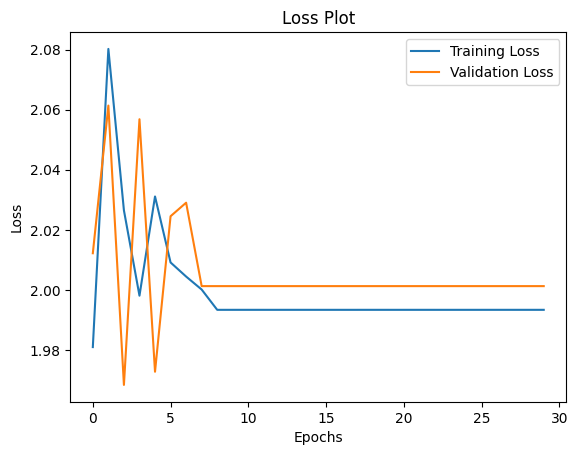

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
np.shape(X_train[0])

(6, 8, 8)

In [ ]:
sample_to_predict = np.expand_dims(X_train[0], axis=0)

# Now, you can use model.predict with the reshaped input
predictions = model.predict(sample_to_predict)


1/1 [==============================] - 0s 80ms/step


In [ ]:
predictions

array([[[[2.37328350e-05, 1.50466949e-04, 2.36284905e-04,
          1.30676694e-04, 2.50809913e-04, 7.03468861e-04,
          1.49470245e-04, 1.97553290e-05],
         [8.36694817e-05, 1.86618418e-04, 3.65657150e-04,
          3.14312405e-04, 4.39496565e-04, 6.20471765e-05,
          9.89247565e-05, 9.53784474e-05],
         [1.84816454e-04, 3.08926567e-04, 4.41171549e-04,
          1.38538750e-03, 2.27606040e-04, 1.95213815e-03,
          1.64267840e-04, 5.80792548e-05],
         [1.28735424e-04, 2.85794376e-04, 1.74657383e-04,
          4.68303333e-04, 7.38862145e-04, 2.14626853e-04,
          2.87527102e-04, 2.16077737e-04],
         [1.39547818e-04, 2.88323179e-04, 5.94326353e-04,
          4.38756659e-04, 2.86869967e-04, 2.56982952e-04,
          7.65595410e-04, 7.08164182e-04],
         [1.06698455e-04, 6.06108108e-04, 2.13171798e-03,
          6.90918008e-04, 2.91165110e-04, 1.14275329e-03,
          2.19592970e-04, 2.58135347e-04],
         [1.52503315e-04, 1.38783231e-04, 8.42

## Hawks Baseline

In [ ]:
X_train = np.load('/content/drive/MyDrive/Tcc/X.npy')
y_train = np.array('/content/drive/MyDrive/Tcc/y.npy')

In [ ]:
X_train = np.array(X)
y_train = np.array(y)

hidden_size = 200

model = keras.Sequential([
    keras.layers.Conv2D(hidden_size, (3, 3), activation='relu', input_shape=(6, 8, 8), padding='same',data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(hidden_size, (3, 3), activation='selu', padding='same',data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(hidden_size, (3, 3), activation='selu', padding='same',data_format='channels_first'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(hidden_size, (3, 3), activation="softmax",padding='same',data_format='channels_first')
])




model.compile(optimizer='adam', loss=custom_loss)  #
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

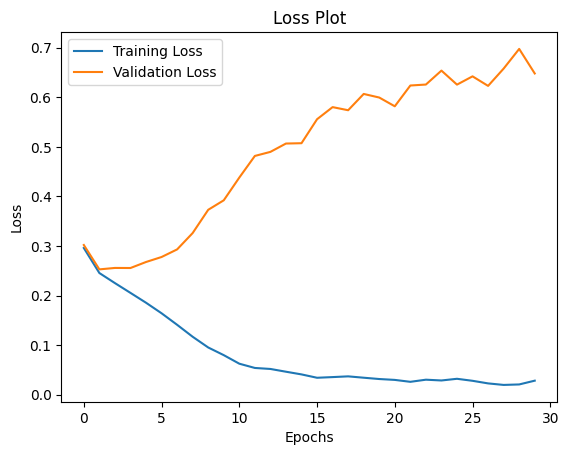

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add
from tensorflow.keras.models import Model

input_layer = Input(shape=(6, 8, 8))

hidden_size = 200
x = Conv2D(hidden_size, (3, 3), activation='relu', padding='same', data_format='channels_first')(input_layer)
skip = Conv2D(hidden_size, (3, 3), activation='selu', padding='same', data_format='channels_first')(x)
x = Conv2D(hidden_size, (3, 3), activation='selu', padding='same', data_format='channels_first')(x)
x = BatchNormalization()(x)
x = Conv2D(hidden_size, (3, 3), activation='selu', padding='same', data_format='channels_first')(x)
x = BatchNormalization()(x)
x = keras.layers.add([x, skip])
x = Conv2D(hidden_size, (3, 3), activation="softmax", padding='same', data_format='channels_first')(x)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model = Model(inputs=input_layer, outputs=x)
model.compile(optimizer=custom_optimizer, loss=custom_loss)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32)

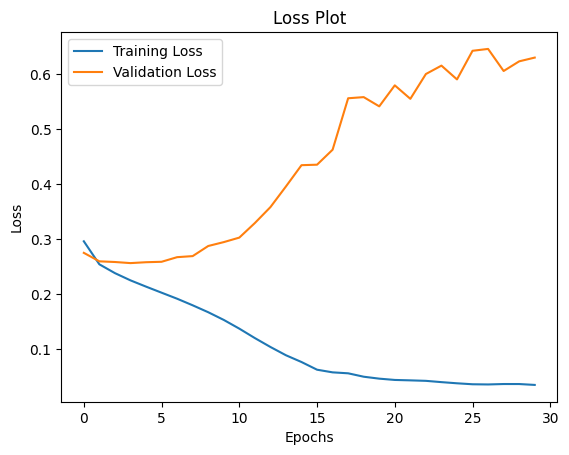

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Hawks Handle Overfitting

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Add
from tensorflow.keras.models import Model

X_train = np.array(X)
y_train = np.array(y)

input_layer = Input(shape=(6, 8, 8))

hidden_size = 200

x = Conv2D(hidden_size, (3, 3), activation='relu', padding='same', data_format='channels_first')(input_layer)
skip = Conv2D(hidden_size, (3, 3), activation='selu', padding='same', data_format='channels_first')(x)
x = Conv2D(hidden_size, (3, 3), activation='selu', padding='same', data_format='channels_first', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Conv2D(hidden_size, (3, 3), activation='selu', padding='same', data_format='channels_first', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = keras.layers.add([x, skip])
x = Conv2D(hidden_size, (3, 3), activation="softmax", padding='same', data_format='channels_first', kernel_regularizer=regularizers.l2(0.01))(x)
custom_optimizer = keras.optimizers.Adam(learning_rate=0.001)
model = Model(inputs=input_layer, outputs=x)
model.compile(optimizer=custom_optimizer, loss=custom_loss)
lr_scheduler = keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 / (10 ** (epoch // 10)))
early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2, batch_size=32, callbacks=[lr_scheduler, early_stopping])


Epoch 1/30
336/336 [==============================] - 19s 9ms/step - loss: 0.9334 - val_loss: 0.3369 - lr: 0.0010
Epoch 2/30
336/336 [==============================] - 3s 8ms/step - loss: 0.3218 - val_loss: 0.3168 - lr: 0.0010
Epoch 3/30
336/336 [==============================] - 3s 9ms/step - loss: 0.2999 - val_loss: 0.2978 - lr: 0.0010
Epoch 4/30
336/336 [==============================] - 3s 10ms/step - loss: 0.2869 - val_loss: 0.2983 - lr: 0.0010
Epoch 5/30
336/336 [==============================] - 3s 8ms/step - loss: 0.2756 - val_loss: 0.2945 - lr: 0.0010
Epoch 6/30
336/336 [==============================] - 3s 8ms/step - loss: 0.2651 - val_loss: 0.2856 - lr: 0.0010
Epoch 7/30
336/336 [==============================] - 3s 8ms/step - loss: 0.2536 - val_loss: 0.2822 - lr: 0.0010
Epoch 8/30
336/336 [==============================] - 3s 9ms/step - loss: 0.2406 - val_loss: 0.2735 - lr: 0.0010
Epoch 9/30
336/336 [==============================] - 3s 9ms/step - loss: 0.2308 - val_loss: 0

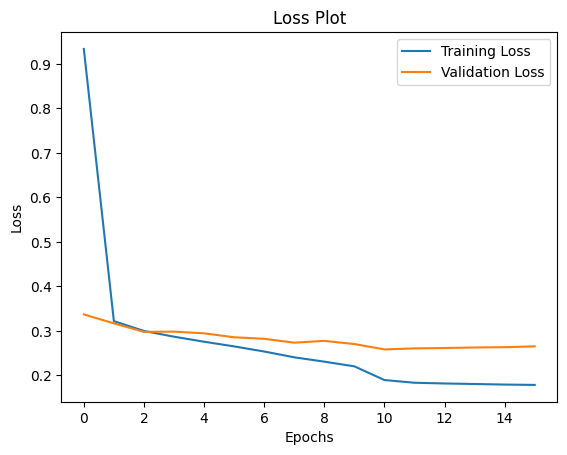

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Play game

In [ ]:
!pip install chess

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00


In [ ]:
def custom_loss(output, target):
    from_loss = tf.keras.losses.CategoricalCrossentropy()
    to_loss = tf.keras.losses.CategoricalCrossentropy()
    loss = from_loss(output[:,0,:], target[:,0,:]) + to_loss(output[:,1,:], target[:,1,:])
    return loss

In [ ]:
import tensorflow as tf
custom_objects = {'custom_loss': custom_loss}
model = tf.keras.models.load_model('/content/drive/MyDrive/Tcc/hawks_v3.h5',custom_objects=custom_objects,compile=False)
model.layers[0].data_format = 'channels_last'
model.compile(optimizer=custom_optimizer, loss=custom_loss)

In [ ]:
alphabet_to_number = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7
}

number_to_alphabet = {v: k for k, v in alphabet_to_number.items()}

import numpy as np
def fen_to_numeric(fen_string,piece):
    piece_placement = fen_string.split()[0]
    board = [[0] * 8 for _ in range(8)]
    row_index = 0
    col_index = 0

    for char in piece_placement:
        if char == '/':
            row_index += 1
            col_index = 0
        elif char.isdigit():
            col_index += int(char)
        elif char.lower() == piece.lower():
            piece_value = 1
            if char.islower():
                piece_value *= -1
            board[row_index][col_index] = piece_value
            col_index += 1
        else:
          board[row_index][col_index] = 0
          col_index += 1

    return board

def matrix_board(board):
  pieces = ["p","k","r","n","q","b"]
  layers = []
  for piece in pieces:
    layers.append(fen_to_numeric(board.fen(),piece))
  return np.stack(layers)

def move_matrix(move):
  uci_move = move

  from_output_layer = np.zeros((8,8))
  from_row= 8 - int(uci_move[1])
  from_column= alphabet_to_number[uci_move[0]]
  from_output_layer[from_row, from_column] = 1

  to_output_layer = np.zeros((8,8))
  to_row = 8 - int(uci_move[3])
  tow_column = alphabet_to_number[uci_move[2]]
  to_output_layer[to_row, tow_column] = 1
  return np.stack([from_output_layer,to_output_layer])

In [ ]:
def distribution(probabilities):
  dist = np.exp(np.array(probabilities))
  dist = (dist/dist.sum())**3
  return dist/dist.sum()

def hawks(board,ply):
  previous_position = matrix_board(board)
  matrix = np.moveaxis(np.expand_dims(previous_position, axis=0), 1, 1)

  if board.turn == False:
    matrix *= -1

  predictions = model.predict(matrix)

  y = predictions[0,:,:]

  vals = []
  froms =  [str(legal_move)[:2] for legal_move in board.legal_moves]
  froms = list(set(froms))
  for from_ in froms:
    val = y[0,:,:][8 - int(from_[1]), alphabet_to_number[from_[0]]]
    vals.append(val)

  probs = distribution(vals)
  choosen = str(np.random.choice(froms, size=1, p=probs)[0])[:2]

  values = []
  moves = []
  for move in list(board.legal_moves):
    if choosen == str(move)[:2]:
      to = str(move)[2:]
      val = y[1,:,:][8 - int(to[1]), alphabet_to_number[to[0]]]
      values.append(val)
      moves.append(choosen+to)
  choice = moves[np.argmax(values)]
  return chess.Move.from_uci(choice)

In [ ]:
import time
import chess
import chess.polyglot as plg
import random
import inspect
from IPython.display import display, HTML, clear_output
from datetime import datetime
import chess.pgn
def who(player):
    return "White" if player == chess.WHITE else "Black"
def display_board(board, use_svg):
    if use_svg:
        return board._repr_svg_()
    else:
        return "<pre>" + str(board) + "</pre>"

# Meus incrementos
def controle_de_vantagem(board):
  scoreW = 0
  scoreB = 0
  pawn, knight, bishop, queen = chess.PAWN,chess.KNIGHT,chess.BISHOP, chess.QUEEN
  dic = {pawn:1, knight:3,bishop:3.15,chess.ROOK:5,queen:10}

  for piece, value in dic.items():
    scoreW+= len(board.pieces(piece, chess.WHITE)) * value
    scoreB+= len(board.pieces(piece, chess.BLACK)) * value

  resultW = "{:.2f}".format(scoreW - scoreB)
  resultB = "{:.2f}".format(scoreB - scoreW)

  resultado = ("White:" + str(resultW) + ", BLack:" + str(resultB))

  return resultado


def play_game(player1, ply1, player2, ply2, visual="svg", pause=0.1):
    use_svg = (visual == "svg")
    board = chess.Board()
    partida = chess.pgn.Game()
    partida.headers["Event"] = "Partida de teste contra outros bots"
    partida.headers["Date"] = datetime.today().strftime('%Y-%m-%d')
    partida.headers["White"] = str(player1)
    partida.headers["White"] = str(player2)

    try:
        while not board.is_game_over(claim_draw=True):
            i = 0
            if board.turn == chess.WHITE:
              if inspect.isclass(player1):
                uci = player1(board,ply1)
                uci = uci.movement(ply1)
              else:
                uci = player1(board,ply1)
            else:
              if inspect.isclass(player2):
                uci = player2(board,ply1)
                uci = uci.movement(ply1)
              else:
                uci = player2(board,ply2)
            name = who(board.turn)
            board.push(uci)
            print(uci)
            if i ==0:
              node = partida.add_variation(uci)
            else:
              node = node.add_variation(uci)
            i+=1
            controle = controle_de_vantagem(board)
            board_stop = display_board(board, use_svg)
            html = "<b>Vantagem :'%s',Move %s %s, Play '%s':</b><br/>%s" % (controle,
                       len(board.move_stack), name, uci, board_stop)
            if visual is not None:
                if visual == "svg":
                    clear_output(wait=True)
                display(HTML(html))
                if visual == "svg":
                    time.sleep(pause)
    except KeyboardInterrupt:
        msg = "Game interrupted!"
        return (None, msg, board)
    result = None
    if board.is_checkmate():
        msg = "checkmate: " + who(not board.turn) + " wins!"
        result = not board.turn
        if result == "White":
          partida.headers["Result"] = "1-0"
        else:
          partida.headers["Result"] = "0-1"
    elif board.is_stalemate():
        msg = "draw: stalemate"
        partida.headers["Result"] = "1/2-1/2"
    elif board.is_fivefold_repetition():
        msg = "draw: 5-fold repetition"
        partida.headers["Result"] = "1/2-1/2"
    elif board.is_insufficient_material():
        msg = "draw: insufficient material"
        partida.headers["Result"] = "1/2-1/2"
    elif board.can_claim_draw():
        msg = "draw: claim"
        partida.headers["Result"] = "1/2-1/2"
    if visual is not None:
        print(msg)
    print(partida)
    return (result, msg, board, partida)

In [ ]:
def dumb_player(board,ply):
  return random.choice(list(board.legal_moves))

In [ ]:
play_game(hawks,2,dumb_player,2)

In [ ]:
model.save('/content/drive/MyDrive/Tcc/hawks_v4.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
